# Image Classification With Tensorflow



Classifying images from the dataset as dog vs cat 

## Concepts Used 
* Building _data input pipelines_ using the `tf.keras.preprocessing.image.ImageDataGenerator` class — Efficiently working with data on disk to interface with our model.
* _Overfitting_ - recognising it, ways to prevent it.
* _Data Augmentation_ and _Dropout_ - Key techniques to fight overfitting in computer vision tasks that we will incorporate into our data pipeline and image classifier model.

## Machine learning workflow followed:

1. Examine and understand data
2. Build an input pipeline
3. Build our model
4. Train our model
5. Test our model
6. Improve our model/Repeat the process



# Importing packages

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

To build the image classifier, the dataset used is a filtered version of <a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">Dogs vs. Cats</a> dataset from Kaggle (provided by Microsoft Research).

The class `tf.keras.preprocessing.image.ImageDataGenerator` will read data from disk. 

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

68608000/68606236 [==============================] - 1s 0us/step


The dataset has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

Assigning variables with the proper file path for the training and validation sets.

In [5]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [6]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

In [7]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [8]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

In [9]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [10]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, flow_from_directory method will load images from the disk, apply rescaling, and resize them using single line of code.



In [11]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 2000 images belonging to 2 classes.


In [12]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 1000 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using matplotlib.

In [13]:
sample_training_images, _ = next(train_data_gen) 

The next function returns a batch from the dataset. One batch is a tuple of (many images, many labels). For right now, we're discarding the labels because we just want to look at the images.

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

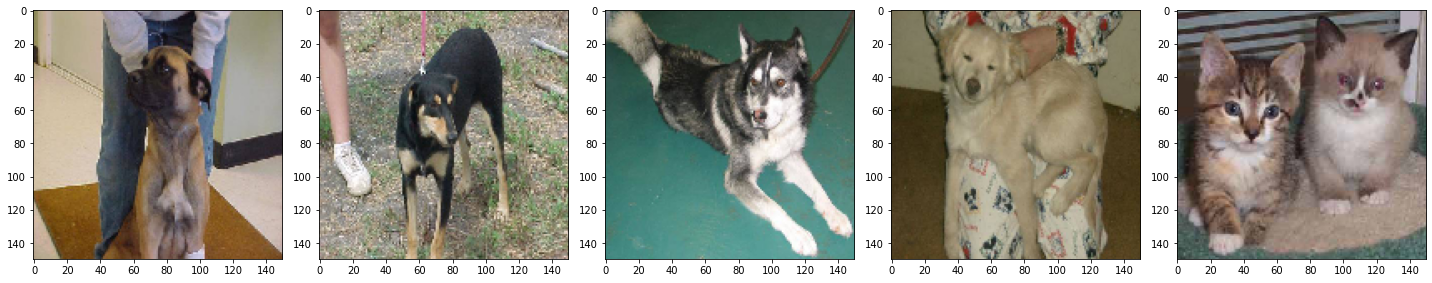

In [15]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [19]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
20/20 [==============================] - 10s 504ms/step - loss: 0.7058 - accuracy: 0.5230 - val_loss: 0.6916 - val_accuracy: 0.5530
Epoch 2/100
20/20 [==============================] - 10s 504ms/step - loss: 0.6871 - accuracy: 0.5465 - val_loss: 0.6869 - val_accuracy: 0.5440
Epoch 3/100
20/20 [==============================] - 10s 507ms/step - loss: 0.6688 - accuracy: 0.5820 - val_loss: 0.6260 - val_accuracy: 0.6450
Epoch 4/100
20/20 [==============================] - 10s 501ms/step - loss: 0.6255 - accuracy: 0.6440 - val_loss: 0.6014 - val_accuracy: 0.6790
Epoch 5/100
20/20 [==============================] - 10s 496ms/step - loss: 0.5861 - accuracy: 0.6850 - val_loss: 0.5909 - val_accuracy: 0.6820
Epoch 6/100
20/20 [==============================] - 10s 495ms/step - loss: 0.5363 - accuracy: 0.7265 - val_loss: 0.5787 - val_accuracy: 0.6950
Epoch 7/100
20/20 [==============================] - 10s 499

### Visualizing results of the training

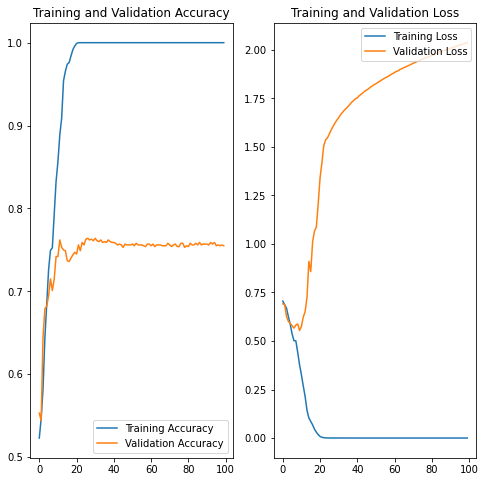

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


As seen from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 70% accuracy on the validation set.

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.



# Data Augmentation

Overfitting often occurs when we have a small number of training examples. One way to fix this problem is to augment our dataset so that it has sufficient number and variety of training examples. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples through random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This exposes the model to more aspects of the data, allowing it to generalize better.

In **tf.keras** we can implement this using the same **ImageDataGenerator** class we used before. We can simply pass different transformations we would want to our dataset as a form of arguments and it will take care of applying it to the dataset during our training process.

Here, I have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to the training images.

In [21]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

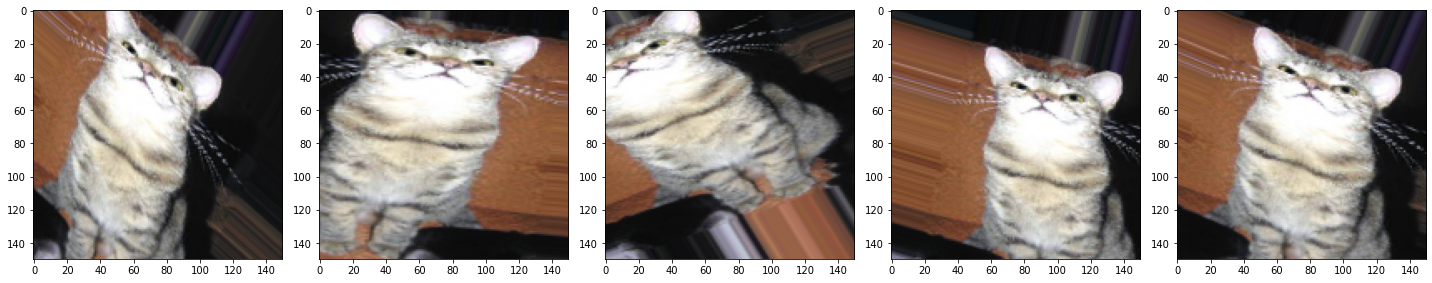

In [22]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Data augmentation is applied only to training examples, since the original images should be representative of what our model needs to manage. So, in this case the previously created one works (only rescaled batches).

### Adding Dropout Regularization

Before the final Dense layers, a Dropout probability of 0.5 is applied to avoid overfitting.

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2)
])

### Recompiling

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Re-training

In [25]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/100
20/20 [==============================] - 19s 964ms/step - loss: 0.7223 - accuracy: 0.5025 - val_loss: 0.6865 - val_accuracy: 0.5180
Epoch 2/100
20/20 [==============================] - 19s 947ms/step - loss: 0.6854 - accuracy: 0.5420 - val_loss: 0.6516 - val_accuracy: 0.6390
Epoch 3/100
20/20 [==============================] - 19s 952ms/step - loss: 0.6780 - accuracy: 0.5545 - val_loss: 0.6461 - val_accuracy: 0.6220
Epoch 4/100
20/20 [==============================] - 19s 956ms/step - loss: 0.6688 - accuracy: 0.5790 - val_loss: 0.6532 - val_accuracy: 0.5530
Epoch 5/100
20/20 [==============================] - 19s 958ms/step - loss: 0.6594 - accuracy: 0.5945 - val_loss: 0.6457 - val_accuracy: 0.6260
Epoch 6/100
20/20 [==============================] - 19s 949ms/step - loss: 0.6521 - accuracy: 0.6275 - val_loss: 0.6572 - val_accuracy: 0.5560
Epoch 7/100
20/20 [==============================] - 19s 958ms/step - loss: 0.6422 - accuracy: 0.6290 - val_loss: 0.6107 - val_accuracy:

### Re-visulisation

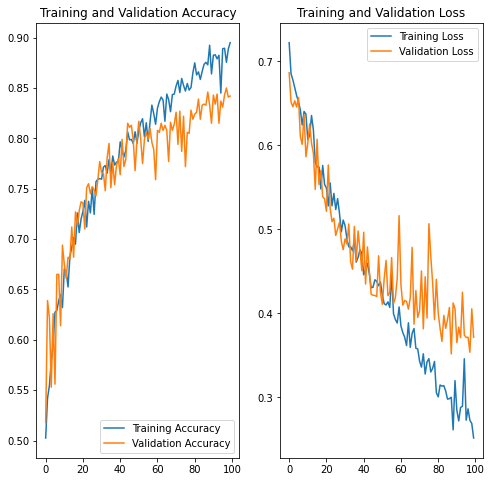

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The accuracy and validation graphs look much better than before. Validation accuracy continues to follow the training graph upto epoch 60, and similarly the loss goes down for both until epoch 60. This means we should proabably stop training after 60 epochs.

# Transfer Learning

Using the pre-trained VGG-16 MobileNet v2 model available on Tensorflow Hub, removing the classification layer from the output-end of the model, then adding a new classification layer to interpret our output. This takes the input shape (224, 224, 3).

In [27]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [28]:
IMAGE_RES = 224

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer

In [29]:
feature_extractor.trainable = False

## Attach a classification head

In [30]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Loading the Tensorflow Cats vs Dogs Dataset


In [31]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:100%]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteMV8EAI/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Reformatting the images to match resolution requirements of MobileNet

In [32]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Train the model

In [33]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 57s 98ms/step - loss: 0.0564 - accuracy: 0.9802 - val_loss: 0.0378 - val_accuracy: 0.9865
Epoch 2/6
582/582 [==============================] - 56s 96ms/step - loss: 0.0306 - accuracy: 0.9900 - val_loss: 0.0304 - val_accuracy: 0.9897
Epoch 3/6
582/582 [==============================] - 56s 97ms/step - loss: 0.0253 - accuracy: 0.9913 - val_loss: 0.0435 - val_accuracy: 0.9850
Epoch 4/6
582/582 [==============================] - 56s 96ms/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.0421 - val_accuracy: 0.9871
Epoch 5/6
582/582 [==============================] - 56s 96ms/step - loss: 0.0199 - accuracy: 0.9922 - val_loss: 0.0347 - val_accuracy: 0.9893
Epoch 6/6
582/582 [==============================] - 56s 95ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.0323 - val_accuracy: 0.9905


Noted 97% validation accuracy, remarkably higher than previous ~83%. The reason for this difference is that MobileNet was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).


Following are the plots of training and validation accuracy/loss graphs.


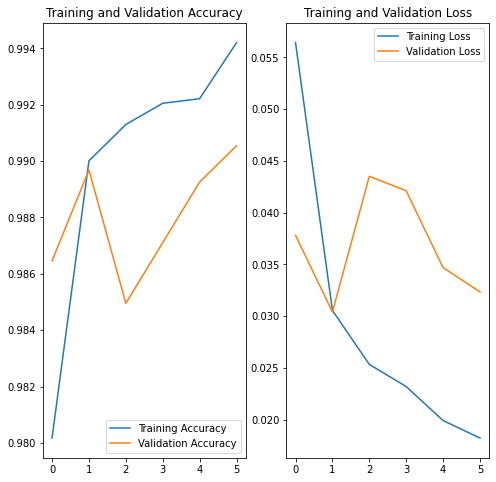

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Dogs and Cats images. While doing training, the network is still performing image augmentation on the training images, but not on the validation dataset. This means the training images may be harder to classify compared to the normal images in the validation dataset.